In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dca import synth_data, cov_util
from dca.dca import DynamicalComponentsAnalysis as DCA
from sklearn.cross_decomposition import CCA

from dca_research import pf_dca
from imp import reload

In [31]:
X = synth_data.gen_lorenz_data(100000)[::3]
X += np.random.randn(*X.shape) / 50.

In [32]:
model1 = DCA(T=3, d=1, verbose=True, n_init=5)
model1.fit(X)

PI: 1.7476 nats, reg: 0.0
PI: 1.7911 nats, reg: 0.0103
PI: 1.8167 nats, reg: 0.0264
PI: 1.8333 nats, reg: 0.0166
PI: 1.862 nats, reg: 0.001
PI: 1.8648 nats, reg: 0.0021
PI: 1.8712 nats, reg: 0.0007
PI: 1.8734 nats, reg: 0.0
PI: 1.8741 nats, reg: 0.0001
PI: 1.875 nats, reg: 0.0
PI: 1.8804 nats, reg: 0.0006
PI: 1.8814 nats, reg: 0.002
PI: 1.8858 nats, reg: 0.0051
PI: 1.8922 nats, reg: 0.013
PI: 1.9037 nats, reg: 0.0254
PI: 1.9306 nats, reg: 0.0598
PI: 1.9988 nats, reg: 0.1245
PI: 2.1712 nats, reg: 0.0603
PI: 2.3099 nats, reg: 0.004
PI: 2.3789 nats, reg: 0.0263
PI: 2.45 nats, reg: 0.0846
PI: 2.5477 nats, reg: 0.0
PI: 2.5743 nats, reg: 0.001
PI: 2.5766 nats, reg: 0.0002
PI: 2.5768 nats, reg: 0.0
PI: 2.5768 nats, reg: 0.0
PI: 2.5768 nats, reg: 0.0
PI: 1.7708 nats, reg: 0.0
PI: 1.8255 nats, reg: 0.0108
PI: 1.8668 nats, reg: 0.0026
PI: 1.8703 nats, reg: 0.0001
PI: 1.8774 nats, reg: 0.0002
PI: 1.8804 nats, reg: 0.002
PI: 1.8846 nats, reg: 0.0001
PI: 1.8918 nats, reg: 0.0001
PI: 1.8977 nats, re

In [33]:
reload(pf_dca)
model2 = pf_dca.PastFutureDynamicalComponentsAnalysis(T=1, d=1, verbose=True, n_init=5)
model2.fit(X)

True
True
True
tensor(-0.8121, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-0.6765, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2974, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.4330, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-0.6765, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2974, dtype=torch.float64, grad_fn=<MaxBackward1>)

PI: -0.141 nats, reg: 0.0
True
True
True
tensor(-0.8121, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-0.6765, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2974, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.4330, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-0.6765, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2974, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.7292, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.3055, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.3432, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.9195, dtype=

tensor(0.0018, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5266, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-3.6893e-05, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5266, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5286, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5266, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(4.2651e-06, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5266, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5286, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5266, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-5.6301e-06, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0020, dtype=torch.float64, gr

tensor(1.5083, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-0.0243, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-0.0236, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5203, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5211, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-0.0236, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5203, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-0.0080, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-0.0065, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5245, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5260, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-0.0065, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5245, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-0.0026, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-0.0008, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5259, dtype=torch.float64, grad_fn=

tensor(29.8017, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.1314, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.2376, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2284, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.3345, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.2376, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2284, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0081, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.9032, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3967, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2919, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.9032, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.3967, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-0.0370, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.9431, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.4693, dtype=torch.float64, grad_fn=<MinBa

tensor(1.4952, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.9258, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.5695, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(3.2869e-06, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.9295, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.5680, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.4974, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.9295, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.5680, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(2.9187e-08, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.9303, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.5676, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.4979, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.9303, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.5676, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(6.0640e-10, dtype=torch.float64, grad

tensor(-8.9831e+13, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-7.0462e+13, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(7.2564e+13, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(9.1933e+13, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-7.0462e+13, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(7.2564e+13, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-2.4953e+12, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-1.9573e+12, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2.0157e+12, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2.5537e+12, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-1.9573e+12, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(2.0157e+12, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-6.9314e+10, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-5.4369e+10, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(5.5991e+10, dtype=torch.float64, grad_fn=<MinBackward1>)


tensor(1.2605, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-0.0073, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2161, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2555, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2.4790, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2161, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2555, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0027, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.1972, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2605, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2.4551, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.1972, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2605, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0027, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.1972, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2605, dtype=torch.float64, grad_fn=<MinBac

tensor(-4.8202e-08, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2033, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2600, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2.4633, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2033, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2600, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(2.8657e-09, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2032, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2599, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2.4632, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2032, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2599, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(2.8657e-09, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2032, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.2599, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2.4632, dtype=torch.float64, grad_fn=<MaxBackwar

tensor(23168.0208, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-15193.6252, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(18173.2683, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-2228.6219, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-1683.8731, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2086.4073, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(2631.1562, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-1683.8731, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(2086.4073, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-241.7755, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-184.9515, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(254.9587, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(311.7826, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-184.9515, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(254.9587, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
ten

tensor(0.0020, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0059, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3796, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3835, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0059, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.3796, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0003, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0044, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3789, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3831, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0044, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.3789, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-2.8683e-05, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3788, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3830, dtype=torch.float64, grad_fn=<MaxBackward1>)
ten

True
True
True
tensor(0.0118, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0146, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3831, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3859, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0146, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.3831, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0040, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0077, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3802, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3840, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0077, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.3802, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0013, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3793, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3833, dtype=torch.float64, grad_fn=<MaxBackw

tensor(0.3923, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3933, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0337, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.3923, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0110, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0139, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3833, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3862, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0139, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.3833, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0037, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3803, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.3841, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.3803, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
Tr

True
True
True
tensor(0.0443, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.7432, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.5311, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.2300, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.7432, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5311, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0138, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.6779, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.4179, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.0820, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.6779, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.4179, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0043, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.6559, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.3816, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.0332, dtype=torch.float64, grad_fn=<MaxBackw

True
True
True
tensor(-5.6957e-09, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.6455, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.3647, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.0102, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.6455, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.3647, dtype=torch.float64, grad_fn=<MaxBackward1>)

PI: 8.6101 nats, reg: 0.7352
True
True
True
tensor(-4624983.9520, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-3935996.4224, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(7329278.2488, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(8018265.7784, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(-3935996.4224, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(7329278.2488, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(-128162.5494, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(-109136.2008, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(203899.4718, dtype=to

True
True
True
tensor(0.0147, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.6513, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.3960, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.0326, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.6513, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.3960, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0049, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.6475, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.3751, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.0177, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.6475, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.3751, dtype=torch.float64, grad_fn=<MaxBackward1>)

True
True
True
tensor(0.0016, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.6461, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(1.3682, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(3.0127, dtype=torch.float64, grad_fn=<MaxBackw

In [46]:
print(model1.coef_)
print(model2.coef_[0])
print(model2.coef_[1])

[[0.85867277]
 [0.37212082]
 [0.35243039]]
[[-0.09626522]
 [-0.97098689]
 [-0.21890058]]
[[ 0.14745487]
 [-0.84857133]
 [-0.50811786]]


In [47]:
model3 = CCA(n_components=1, scale=False)
model3.fit(X[:-1], X[1:])

CCA(copy=True, max_iter=500, n_components=1, scale=False, tol=1e-06)

In [48]:
print(model3.x_weights_)
print(model3.y_weights_)

[[ 0.60029   ]
 [ 0.79973687]
 [-0.00853538]]
[[ 0.88998806]
 [ 0.45590841]
 [-0.00829291]]


In [49]:
print(model2.coef_[0])
print(model2.coef_[1])

[[-0.09626522]
 [-0.97098689]
 [-0.21890058]]
[[ 0.14745487]
 [-0.84857133]
 [-0.50811786]]


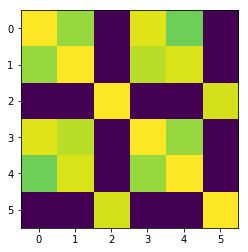

In [52]:
plt.imshow(cov_util.calc_cov_from_cross_cov_mats(model2.cross_covs.numpy()))

In [73]:
np.linalg.eigvalsh(cov_util.calc_cov_from_cross_cov_mats(cov_util.project_cross_cov_mats(model2.cross_covs.numpy(), proj=np.random.randn(3, 1))))

array([0.17651871, 6.67120582])

In [59]:
reload(pf_dca)
d = 3
T = 2
proj = np.random.randn(3, d)
proj2 = np.random.randn(3, d)
ccms = cov_util.calc_cross_cov_mats_from_data(X, T=T*2)
bigcov = cov_util.calc_cov_from_cross_cov_mats(ccms)
cov = pf_dca.calc_cov_from_cross_cov_mats(*pf_dca.project_cross_cov_mats(ccms,
                                          proj,
                                          proj2))
print(np.linalg.eigvalsh(bigcov))
print(np.linalg.eigvalsh(cov))
print(np.linalg.eigvalsh(cov[:T*d, :T*d]))
print(np.linalg.eigvalsh(cov[T*d:, T*d:]))

[3.99415504e-04 4.22473920e-04 5.46138297e-04 1.05531821e-02
 1.55347652e-02 6.30990838e-02 1.18470299e-01 2.89026581e-01
 1.35610888e+00 1.39561977e+00 2.48162353e+00 6.27994811e+00]
[-9.07720623e+00 -7.11862397e-01 -1.59192888e-02  3.07844066e-01
  7.06492643e-01  9.40508211e-01  1.15256354e+00  1.90196929e+00
  4.63809534e+00  1.19027880e+01  1.57259241e+01  1.95870494e+01]
[3.38486279e-05 4.30298797e-03 8.58936875e-01 9.90429894e-01
 6.87895919e+00 1.81425525e+01]
[1.74115942e-03 7.11911338e-02 3.95783902e-01 1.22079537e+00
 2.68869322e+00 1.58048267e+01]


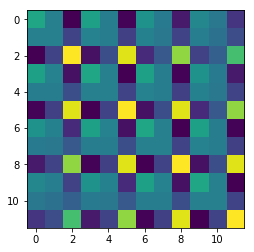

In [51]:
plt.imshow(cov)

In [27]:
cov[:T*d, :T*d]

array([[0.26516654, 0.29181578, 0.25796002, 0.34773863],
       [0.29181578, 4.9699136 , 0.23339058, 4.9152589 ],
       [0.25796002, 0.23339058, 0.26516654, 0.29181578],
       [0.34773863, 4.9152589 , 0.29181578, 4.9699136 ]])

In [28]:
cov[T*d:, T*d:]

array([[3.53797272, 0.50280216, 3.46205367, 0.45072927],
       [0.50280216, 0.38760023, 0.54889284, 0.38101133],
       [3.46205367, 0.54889284, 3.53797272, 0.50280216],
       [0.45072927, 0.38101133, 0.50280216, 0.38760023]])

In [60]:
cpp, cff, cpf = pf_dca.project_cross_cov_mats(ccms, proj, proj2)

In [62]:
np.linalg.eigvalsh(cov_util.calc_cov_from_cross_cov_mats(cpp))

array([3.38486279e-05, 4.30298797e-03, 8.58936875e-01, 9.90429894e-01,
       6.87895919e+00, 1.81425525e+01])

In [63]:
np.allclose(cov[T*d:, :T*d], cov[:T*d, T*d:].T)

True